# Probabilistic Forecasting: Conformal calibration

Conformal prediction is a framework for constructing prediction intervals that are valid with respect to the coverage probability. In addition to generating prediction intervals from point forecasts, conformal methods can also calibrate prediction intervals generated by other techniques, such as quantile regression or bootstrapped residuals. In this case, the conformal method adjusts the prediction intervals to ensure they remain valid with respect to the coverage probability. Skforecast provides this functionality through the `ConformalInterval` transformer.

<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px; padding-right: 10px">

<p class="title">
    <i style="font-size: 18px; color:#ff9100; border-color: #ff1744;"></i>
    <b style="color: #ff9100;"> <span style="color: #ff9100;">&#9888;</span> Warning</b>
</p>

<p>
There are several well-established <a href="https://mapie.readthedocs.io/en/stable/theoretical_description_regression.html" target="_blank">methods for conformal prediction</a>, each with its own characteristics and assumptions. However, when applied to time series forecasting, their coverage guarantees are only valid for one-step-ahead predictions. For multi-step-ahead predictions, the coverage probability is not guaranteed. Skforecast implements Split Conformal Prediction (SCP) due to its simplicity and efficiency. 

</div>


<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>For more examples on how to use probabilistic forecasting, check out the following articles:</p>
<ul>
    <li>
        <a href="https://cienciadedatos.net/documentos/py42-probabilistic-forecasting" target="_blank">
            Probabilistic forecasting with machine learning
        </a>
    </li>
    <li>
        <a href="https://cienciadedatos.net/documentos/py60-probabilistic-forecasting-prediction-intervals-multi-step-forecasting" target="_blank">
            Probabilistic forecasting: prediction intervals for multi-step time series forecasting
        </a>
    </li>
    <li>
        <a href="../faq/probabilistic-forecasting-crps-score.html" target="_blank">
            Continuous Ranked Probability Score (CRPS) in probabilistic forecasting
        </a>
    </li>
</ul>


</div>

## Libraries and data

In [18]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
from skforecast.plot import plot_residuals
from skforecast.plot import plot_prediction_intervals

# Modelling and Forecasting
# ==============================================================================
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster
from skforecast.metrics import calculate_coverage

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')
plt.style.use('seaborn-v0_8-darkgrid')

In [19]:
# Data
# ==============================================================================
data = fetch_dataset(name='ett_m2')
data = data[['OT']]
data.head(2)

ett_m2
------
Data from an electricity transformer station was collected between July 2016 and
July 2018 (2 years x 365 days x 24 hours x 4 intervals per hour = 70,080 data
points). Each data point consists of 8 features, including the date of the
point, the predictive value "Oil Temperature (OT)", and 6 different types of
external power load features: High UseFul Load (HUFL), High UseLess Load (HULL),
Middle UseFul Load (MUFL), Middle UseLess Load (MULL), Low UseFul Load (LUFL),
Low UseLess Load(LULL).
Zhou, Haoyi & Zhang, Shanghang & Peng, Jieqi & Zhang, Shuai & Li, Jianxin &
Xiong, Hui & Zhang, Wancai. (2020). Informer: Beyond Efficient Transformer for
Long Sequence Time-Series Forecasting.
[10.48550/arXiv.2012.07436](https://arxiv.org/abs/2012.07436).
https://github.com/zhouhaoyi/ETDataset
Shape of the dataset: (69680, 7)


,OT
date,
2016-07-01 00:00:00,38.661999
2016-07-01 00:15:00,38.223000


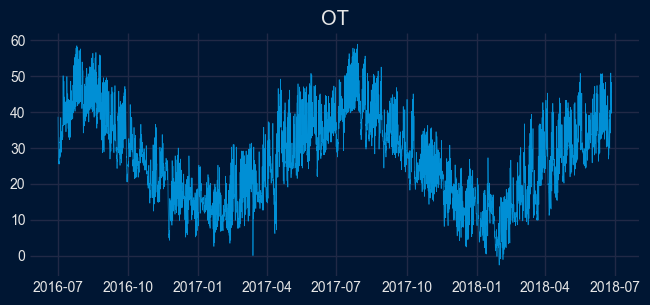

In [20]:
# Plot target time series
# ==============================================================================
set_dark_theme()
plt.rcParams['lines.linewidth'] = 0.5
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(data['OT'])
ax.set_title("OT");

In [21]:
# Calendar features
# ==============================================================================
features_to_extract = [
    'year',
    'month',
    'week',
    'day_of_week',
    'hour'
]
calendar_transformer = DatetimeFeatures(
    variables           = 'index',
    features_to_extract = features_to_extract,
    drop_original       = False,
)

# Cliclical encoding of calendar features
# ==============================================================================
features_to_encode = [
    "month",
    "week",
    "day_of_week",
    "hour",
]
max_values = {
    "month": 12,
    "week": 52,
    "day_of_week": 7,
    "hour": 24,
}
cyclical_encoder = CyclicalFeatures(
                        variables     = features_to_encode,
                        max_values    = max_values,
                        drop_original = True
                   )
exog_transformer = make_pipeline(
                        calendar_transformer,
                        cyclical_encoder
                   )
display(exog_transformer)

data = exog_transformer.fit_transform(data)
# Remove rows with NaNs created by lag features
data = data.dropna()
exog_features = data.columns.difference(['OT']).tolist()
display(data.head(3))

Pipeline(steps=[('datetimefeatures',
                 DatetimeFeatures(drop_original=False,
                                  features_to_extract=['year', 'month', 'week',
                                                       'day_of_week', 'hour'],
                                  variables='index')),
                ('cyclicalfeatures',
                 CyclicalFeatures(drop_original=True,
                                  max_values={'day_of_week': 7, 'hour': 24,
                                              'month': 12, 'week': 52},
                                  variables=['month', 'week', 'day_of_week',
                                             'hour']))])

,OT,year,month_sin,month_cos,week_sin,week_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
date,,,,,,,,,,
2016-07-01 00:00:00,38.661999,2016,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.0,1.0
2016-07-01 00:15:00,38.223000,2016,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.0,1.0
2016-07-01 00:30:00,37.344002,2016,-0.5,-0.866025,1.224647e-16,-1.0,-0.433884,-0.900969,0.0,1.0


In [22]:
# Split train-validation-test
# ==============================================================================
end_train = '2017-09-01 23:59:00'
end_validation = '2018-04-01 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2016-07-01 00:00:00 --- 2017-09-01 23:45:00  (n=41088)
Dates validacion : 2017-09-02 00:00:00 --- 2018-04-01 23:45:00  (n=20352)
Dates test       : 2018-04-02 00:00:00 --- 2018-06-26 19:45:00  (n=8240)


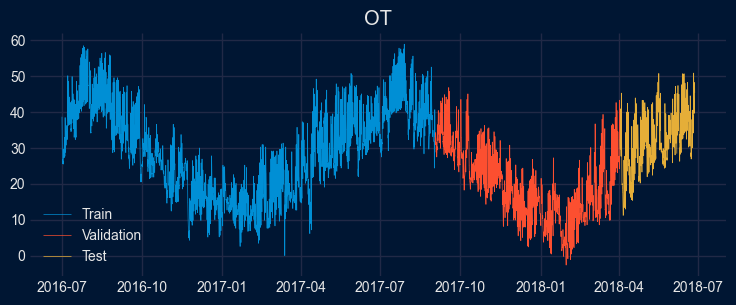

In [23]:
# Plot partitions
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(data_train['OT'], label='Train')
ax.plot(data_val['OT'], label='Validation')
ax.plot(data_test['OT'], label='Test')
ax.set_title('OT')
ax.legend();

## Predictions intervals


## Calibrate prediction intervals

The prediction intervals generated using conformal prediction achieve an empirical coverage very close to the nominal coverage of 80%.